In [ ]:
import hashlib
import numpy as np
from PIL import Image

def md5_file(path, chunk_size=8192):
    h = hashlib.md5()
    with open(path, "rb") as f:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            h.update(chunk)
    return h.hexdigest()

files = ["collision1.png", "exploit.png"]

md5s = {}
for f in files:
    md5s[f] = md5_file(f)
    print(f"{f}: {md5s[f]}")

print("\n=== Compare ===")
if md5s["collision1.png"] == md5s["exploit.png"]:
    print("✅ MD5 MATCH (binary-identical)")
else:
    print("❌ MD5 DIFFERENT")
BUDGET = 55

def load_img(path):
    img = Image.open(path).convert("RGB")
    return np.array(img, dtype=np.int16)  # int16으로 오버플로우 방지

img1 = load_img("collision1.png")
img2 = load_img("exploit.png")

if img1.shape != img2.shape:
    raise ValueError(f"Image size mismatch: {img1.shape} vs {img2.shape}")

diff = np.abs(img2 - img1)
diff_sum = int(diff.sum())

print("\n=== Budget Check ===")
print("Total pixel diff:", diff_sum)
print("Budget:", BUDGET)

if diff_sum <= BUDGET:
    print("✅ Budget check PASSED")
else:
    print("❌ Budget check FAILED")

collision1.png: 053e4fa96efbfd73c79b3f3dccbd9384
exploit.png: ee748ae3b4a7a425b1ae20e6e88150d3

=== Compare ===
❌ MD5 DIFFERENT

=== Budget Check ===
Total pixel diff: 117771
Budget: 55
❌ Budget check FAILED


In [ ]:
import random
from dataclasses import dataclass
from functools import lru_cache
from pathlib import Path
from typing import Callable

import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision.transforms import functional as TF

MNIST_MEAN = 0.1307
MNIST_STD = 0.3081

class MnistNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

@dataclass(frozen=True)
class ModelBundle:
    model: torch.nn.Module
    categories: list
    preprocess_pil: Callable[[Image.Image], torch.Tensor]
    preprocess_tensor: Callable[[torch.Tensor], torch.Tensor]

def set_deterministic(seed: int = 0) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def _to_grayscale_tensor(x: torch.Tensor) -> torch.Tensor:
    # x: (N, C, H, W)
    if x.shape[1] == 1:
        return x
    if x.shape[1] != 3:
        raise ValueError("expected 1 or 3 channels")
    r, g, b = x[:, 0:1], x[:, 1:2], x[:, 2:3]
    return 0.2989 * r + 0.5870 * g + 0.1140 * b

def _preprocess_tensor(x: torch.Tensor) -> torch.Tensor:
    x = _to_grayscale_tensor(x)
    x = TF.resize(x, [28, 28], antialias=True)
    x = TF.center_crop(x, [28, 28])
    mean = torch.tensor([MNIST_MEAN], device=x.device).view(1, 1, 1, 1)
    std = torch.tensor([MNIST_STD], device=x.device).view(1, 1, 1, 1)
    return (x - mean) / std

def _preprocess_pil(img: Image.Image) -> torch.Tensor:
    if img.mode != "L":
        img = img.convert("L")
    x = TF.to_tensor(img).unsqueeze(0)      # (1,1,H,W)
    return _preprocess_tensor(x).squeeze(0) # (1,28,28)

def _build_bundle(device: str = "cpu", weights_path: str = "mnist_cnn.pth") -> ModelBundle:
    model = MnistNet()
    model.eval()
    model.to(device)

    p = Path(weights_path)
    if p.exists():
        state = torch.load(p, map_location=device)
        model.load_state_dict(state)
        print(f"✅ Loaded weights: {p.resolve()}")
    else:
        print(f"⚠️ Weights not found: {p.resolve()} (running with random weights)")

    categories = [str(i) for i in range(10)]
    return ModelBundle(
        model=model,
        categories=categories,
        preprocess_pil=_preprocess_pil,
        preprocess_tensor=_preprocess_tensor,
    )

@lru_cache(maxsize=1)
def get_model_bundle(device: str = "cpu") -> ModelBundle:
    return _build_bundle(device=device, weights_path="mnist_cnn.pth")

def predict_top1(image: Image.Image, bundle: ModelBundle) -> dict:
    x = bundle.preprocess_pil(image).unsqueeze(0)  # (1,1,28,28)
    with torch.no_grad():
        logits = bundle.model(x)
        probs = torch.softmax(logits, dim=1)[0]
    top1 = int(torch.argmax(probs).item())
    return {
        "id": top1,
        "label": bundle.categories[top1],
        "prob": float(probs[top1].item()),
    }

set_deterministic(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
bundle = get_model_bundle(device=device)
print("device:", device)


✅ Loaded weights: /content/mnist_cnn.pth
device: cpu


Prediction: {'id': 0, 'label': '0', 'prob': 0.9885486364364624}


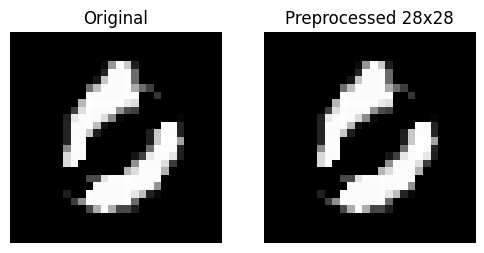

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image


img = Image.open("exploit.png")
pred = predict_top1(img, bundle=bundle)
print("Prediction:", pred)

# 화면 표시 (전처리된 28x28도 같이 보여줌)
x = bundle.preprocess_pil(img)  # (1,28,28)
x_denorm = (x * MNIST_STD + MNIST_MEAN).clamp(0, 1)  # 보기용

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img.convert("L"), cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Preprocessed 28x28")
plt.imshow(x_denorm.squeeze(0).cpu().numpy(), cmap="gray")
plt.axis("off")
plt.show()


Adversarial Outputs Verification

[00] 0 → 1 (budget: 55)
--------------------------------------------------
  ✅ Pixel diff: 18/55
  ✅ Ref pred: 0 (expected: 0, prob: 1.0000)
  ✅ Adv pred: 1 (expected: 1, prob: 0.5479)
  ✅ PASS

[01] 1 → 2 (budget: 30)
--------------------------------------------------
  ✅ Pixel diff: 8/30
  ✅ Ref pred: 1 (expected: 1, prob: 0.9990)
  ✅ Adv pred: 2 (expected: 2, prob: 0.6010)
  ✅ PASS

[02] 2 → 3 (budget: 30)
--------------------------------------------------
  ✅ Pixel diff: 10/30
  ✅ Ref pred: 2 (expected: 2, prob: 0.9999)
  ✅ Adv pred: 3 (expected: 3, prob: 0.5184)
  ✅ PASS

[03] 3 → 4 (budget: 65)
--------------------------------------------------
  ✅ Pixel diff: 13/65
  ✅ Ref pred: 3 (expected: 3, prob: 0.4947)
  ✅ Adv pred: 4 (expected: 4, prob: 0.4432)
  ✅ PASS

[04] 4 → 5 (budget: 30)
--------------------------------------------------
  ✅ Pixel diff: 8/30
  ✅ Ref pred: 4 (expected: 4, prob: 0.9996)
  ✅ Adv pred: 5 (expected: 5, prob: 0.4469)
  ✅

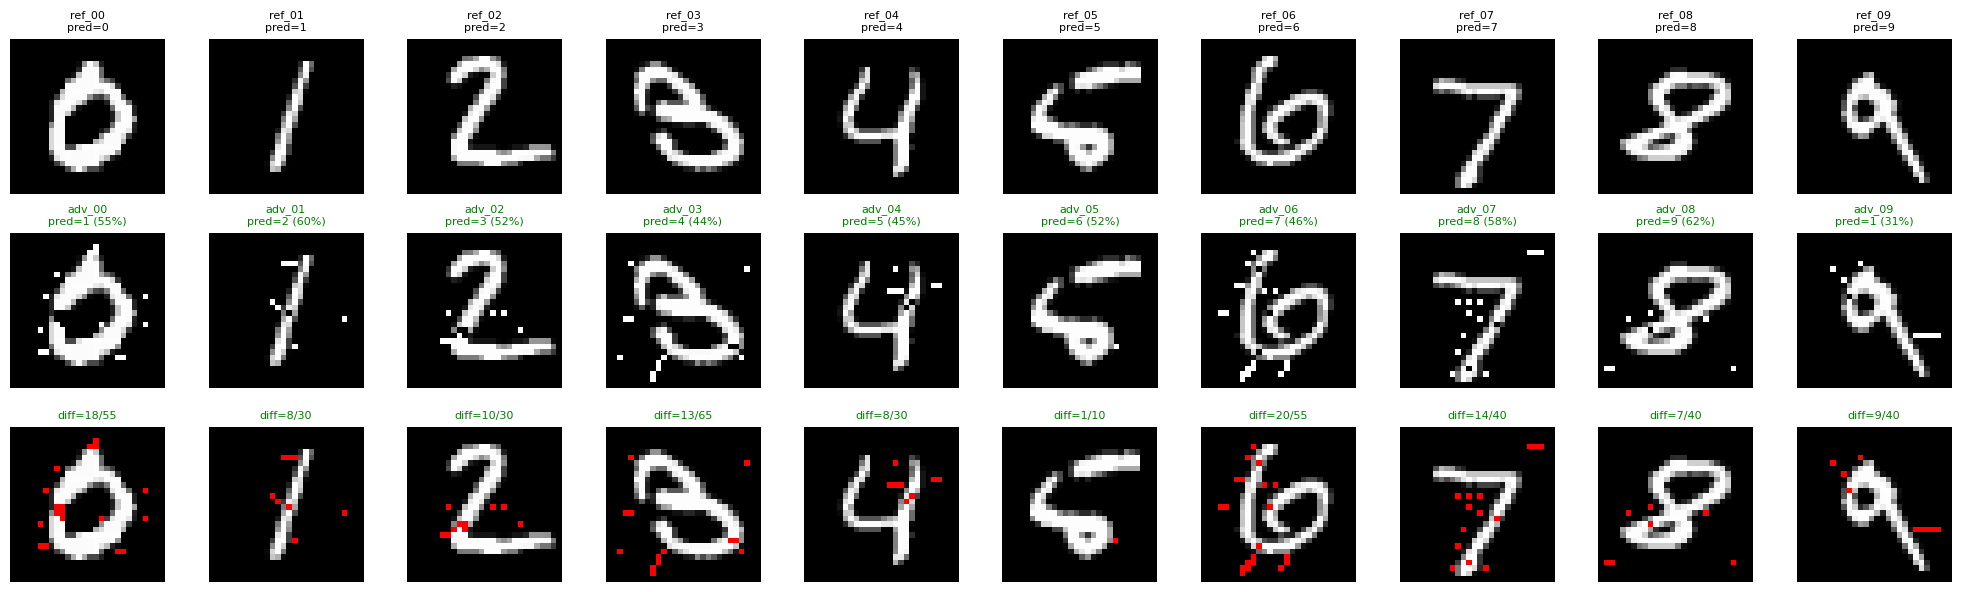

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np

# Config
TARGET_CLASS_IDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 1]
REFERENCE_CLASS_IDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
BUDGETS = [55, 30, 30, 65, 30, 10, 55, 40, 40, 40]

def pixel_diff(a: np.ndarray, b: np.ndarray) -> int:
    """픽셀 단위 차이 개수"""
    return int(np.count_nonzero(a != b))

def verify_adversarial_outputs():
    print("=" * 70)
    print("Adversarial Outputs Verification")
    print("=" * 70)

    results = []

    for i in range(10):
        ref_path = f"ref_{i:02d}.png"
        adv_path = f"adversarial_outputs/adv_{i:02d}.png"

        source_class = REFERENCE_CLASS_IDS[i]
        target_class = TARGET_CLASS_IDS[i]
        budget = BUDGETS[i]

        print(f"\n[{i:02d}] {source_class} → {target_class} (budget: {budget})")
        print("-" * 50)

        # 파일 존재 확인
        if not Path(ref_path).exists():
            print(f"  ❌ {ref_path} not found")
            results.append({'index': i, 'success': False, 'reason': 'ref not found'})
            continue
        if not Path(adv_path).exists():
            print(f"  ❌ {adv_path} not found")
            results.append({'index': i, 'success': False, 'reason': 'adv not found'})
            continue

        # 이미지 로드
        ref_img = Image.open(ref_path).convert("L")
        adv_img = Image.open(adv_path).convert("L")

        ref_arr = np.array(ref_img, dtype=np.uint8)
        adv_arr = np.array(adv_img, dtype=np.uint8)

        # 1. Pixel diff 확인
        diff = pixel_diff(ref_arr, adv_arr)
        diff_ok = diff <= budget
        diff_status = "✅" if diff_ok else "❌"
        print(f"  {diff_status} Pixel diff: {diff}/{budget}")

        # 2. Ref 예측 확인
        ref_pred = predict_top1(ref_img, bundle)
        ref_ok = ref_pred['id'] == source_class
        ref_status = "✅" if ref_ok else "❌"
        print(f"  {ref_status} Ref pred: {ref_pred['id']} (expected: {source_class}, prob: {ref_pred['prob']:.4f})")

        # 3. Adv 예측 확인
        adv_pred = predict_top1(adv_img, bundle)
        adv_ok = adv_pred['id'] == target_class
        adv_status = "✅" if adv_ok else "❌"
        print(f"  {adv_status} Adv pred: {adv_pred['id']} (expected: {target_class}, prob: {adv_pred['prob']:.4f})")

        # 전체 성공 여부
        success = diff_ok and ref_ok and adv_ok
        overall_status = "✅ PASS" if success else "❌ FAIL"
        print(f"  {overall_status}")

        results.append({
            'index': i,
            'source': source_class,
            'target': target_class,
            'budget': budget,
            'pixel_diff': diff,
            'ref_pred': ref_pred['id'],
            'adv_pred': adv_pred['id'],
            'ref_prob': ref_pred['prob'],
            'adv_prob': adv_pred['prob'],
            'diff_ok': diff_ok,
            'ref_ok': ref_ok,
            'adv_ok': adv_ok,
            'success': success
        })

    # Summary
    print("\n" + "=" * 70)
    print("SUMMARY")
    print("=" * 70)

    success_count = sum(1 for r in results if r.get('success', False))
    print(f"\nTotal: {success_count}/10 passed\n")

    for r in results:
        if 'reason' in r:
            print(f"  [{r['index']:02d}] ❌ {r['reason']}")
        else:
            status = "✅" if r['success'] else "❌"
            issues = []
            if not r['diff_ok']:
                issues.append(f"diff={r['pixel_diff']}/{r['budget']}")
            if not r['ref_ok']:
                issues.append(f"ref={r['ref_pred']}!={r['source']}")
            if not r['adv_ok']:
                issues.append(f"adv={r['adv_pred']}!={r['target']}")

            issue_str = f" ({', '.join(issues)})" if issues else ""
            print(f"  [{r['index']:02d}] {status} {r['source']}→{r['target']}: "
                  f"diff={r['pixel_diff']}/{r['budget']}, "
                  f"adv_pred={r['adv_pred']} (prob={r['adv_prob']:.2%}){issue_str}")

    return results


def visualize_adversarial_outputs(results=None):
    """시각화"""
    fig, axes = plt.subplots(3, 10, figsize=(20, 6))

    for i in range(10):
        ref_path = f"ref_{i:02d}.png"
        adv_path = f"adversarial_outputs/adv_{i:02d}.png"

        if not Path(ref_path).exists() or not Path(adv_path).exists():
            continue

        ref_img = Image.open(ref_path).convert("L")
        adv_img = Image.open(adv_path).convert("L")

        ref_arr = np.array(ref_img)
        adv_arr = np.array(adv_img)

        ref_pred = predict_top1(ref_img, bundle)
        adv_pred = predict_top1(adv_img, bundle)

        diff = pixel_diff(ref_arr, adv_arr)
        budget = BUDGETS[i]
        target = TARGET_CLASS_IDS[i]

        success = (diff <= budget) and (adv_pred['id'] == target)
        color = 'green' if success else 'red'

        # Row 0: Reference
        axes[0, i].imshow(ref_arr, cmap='gray', vmin=0, vmax=255)
        axes[0, i].set_title(f"ref_{i:02d}\npred={ref_pred['id']}", fontsize=8)
        axes[0, i].axis('off')

        # Row 1: Adversarial
        axes[1, i].imshow(adv_arr, cmap='gray', vmin=0, vmax=255)
        axes[1, i].set_title(f"adv_{i:02d}\npred={adv_pred['id']} ({adv_pred['prob']:.0%})",
                            fontsize=8, color=color)
        axes[1, i].axis('off')

        # Row 2: Diff highlight
        diff_rgb = np.stack([ref_arr, ref_arr, ref_arr], axis=-1)
        changed = ref_arr != adv_arr
        diff_rgb[changed] = [255, 0, 0]
        axes[2, i].imshow(diff_rgb)
        axes[2, i].set_title(f"diff={diff}/{budget}", fontsize=8,
                            color='green' if diff <= budget else 'red')
        axes[2, i].axis('off')

    axes[0, 0].set_ylabel("Reference", fontsize=10)
    axes[1, 0].set_ylabel("Adversarial", fontsize=10)
    axes[2, 0].set_ylabel("Changed (red)", fontsize=10)

    plt.tight_layout()
    plt.savefig("adversarial_outputs/verification.png", dpi=150)
    plt.show()


# 실행
results = verify_adversarial_outputs()
visualize_adversarial_outputs(results)

In [ ]:
# ============================================
# Submission.zip 검증 코드 (Colab용)
# verification.py 로직 그대로 재현
# ============================================

import hashlib
import io
import zipfile
import numpy as np
from PIL import Image

# Config
TARGET_CLASS_IDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 1]
REFERENCE_CLASS_IDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
BUDGETS = [55, 30, 30, 65, 30, 10, 55, 40, 40, 40]

def md5_hex(data: bytes) -> str:
    return hashlib.md5(data).hexdigest()

def pixel_diff(a: np.ndarray, b: np.ndarray) -> int:
    if a.shape != b.shape:
        raise ValueError("shape mismatch")
    diff = a != b
    return int(np.count_nonzero(diff))

def verify_submission(zip_path: str, refs_dir: str = "."):
    """
    submission.zip을 verification.py 로직대로 검증
    """
    print("=" * 70)
    print("📦 Submission Verification")
    print("=" * 70)

    with zipfile.ZipFile(zip_path, 'r') as zf:
        entries = zf.namelist()
        print(f"\nFiles in ZIP: {len(entries)}")
        print(entries[:5], "..." if len(entries) > 5 else "")

        # 파일명 검증
        expected = set()
        for i in range(10):
            expected.add(f"pair_{i:02d}_img1.png")
            expected.add(f"pair_{i:02d}_img2.png")

        if set(entries) != expected:
            print(f"\n❌ File list mismatch!")
            print(f"   Expected: {sorted(expected)}")
            print(f"   Got: {sorted(entries)}")
            missing = expected - set(entries)
            extra = set(entries) - expected
            if missing:
                print(f"   Missing: {missing}")
            if extra:
                print(f"   Extra: {extra}")
            return False

        print("✅ File list OK")

        all_pass = True
        results = []

        for i in range(10):
            print(f"\n[{i:02d}] ref_{i:02d} | {REFERENCE_CLASS_IDS[i]} → {TARGET_CLASS_IDS[i]} (budget: {BUDGETS[i]})")
            print("-" * 60)

            # Reference 이미지 로드
            ref_path = f"{refs_dir}/ref_{i:02d}.png"
            try:
                ref_img = Image.open(ref_path).convert("L")
                ref_arr = np.array(ref_img, dtype=np.uint8)
            except Exception as e:
                print(f"  ❌ Cannot load {ref_path}: {e}")
                all_pass = False
                continue

            # ZIP에서 이미지 로드
            img1_name = f"pair_{i:02d}_img1.png"
            img2_name = f"pair_{i:02d}_img2.png"

            img1_bytes = zf.read(img1_name)
            img2_bytes = zf.read(img2_name)

            try:
                img1 = Image.open(io.BytesIO(img1_bytes)).convert("L")
                img2 = Image.open(io.BytesIO(img2_bytes)).convert("L")
            except Exception as e:
                print(f"  ❌ Cannot open images: {e}")
                all_pass = False
                continue

            img1_arr = np.array(img1, dtype=np.uint8)
            img2_arr = np.array(img2, dtype=np.uint8)

            checks = {}

            # 1. img1 shape == ref shape
            if img1_arr.shape != ref_arr.shape:
                print(f"  ❌ img1 shape mismatch: {img1_arr.shape} vs {ref_arr.shape}")
                checks['img1_shape'] = False
                all_pass = False
            else:
                checks['img1_shape'] = True

            # 2. img1 == ref (pixel perfect)
            diff1 = pixel_diff(ref_arr, img1_arr)
            if diff1 != 0:
                print(f"  ❌ img1 != ref (diff: {diff1} pixels)")
                checks['img1_identical'] = False
                all_pass = False
            else:
                print(f"  ✅ img1 == ref (pixel perfect)")
                checks['img1_identical'] = True

            # 3. img2 shape == ref shape
            if img2_arr.shape != ref_arr.shape:
                print(f"  ❌ img2 shape mismatch: {img2_arr.shape} vs {ref_arr.shape}")
                checks['img2_shape'] = False
                all_pass = False
            else:
                checks['img2_shape'] = True

            # 4. img2 diff <= budget
            diff2 = pixel_diff(ref_arr, img2_arr)
            budget = BUDGETS[i]
            if diff2 > budget:
                print(f"  ❌ img2 diff: {diff2} > budget {budget}")
                checks['img2_budget'] = False
                all_pass = False
            else:
                print(f"  ✅ img2 diff: {diff2} <= budget {budget}")
                checks['img2_budget'] = True

            # 5. MD5 match ⭐ 핵심!
            md5_1 = md5_hex(img1_bytes)
            md5_2 = md5_hex(img2_bytes)
            if md5_1 != md5_2:
                print(f"  ❌ MD5 mismatch!")
                print(f"     img1: {md5_1}")
                print(f"     img2: {md5_2}")
                checks['md5_match'] = False
                all_pass = False
            else:
                print(f"  ✅ MD5 match: {md5_1}")
                checks['md5_match'] = True

            # 6. img1 prediction == reference_class
            img1_pred = predict_top1(img1, bundle)
            expected_ref_class = REFERENCE_CLASS_IDS[i]
            if img1_pred['id'] != expected_ref_class:
                print(f"  ❌ img1 pred: {img1_pred['id']} != expected {expected_ref_class}")
                checks['img1_pred'] = False
                all_pass = False
            else:
                print(f"  ✅ img1 pred: {img1_pred['id']} (prob: {img1_pred['prob']:.4f})")
                checks['img1_pred'] = True

            # 7. img2 prediction == target_class
            img2_pred = predict_top1(img2, bundle)
            expected_target_class = TARGET_CLASS_IDS[i]
            if img2_pred['id'] != expected_target_class:
                print(f"  ❌ img2 pred: {img2_pred['id']} != expected {expected_target_class}")
                checks['img2_pred'] = False
                all_pass = False
            else:
                print(f"  ✅ img2 pred: {img2_pred['id']} (prob: {img2_pred['prob']:.4f})")
                checks['img2_pred'] = True

            # 결과 저장
            pair_pass = all(checks.values())
            status = "✅ PASS" if pair_pass else "❌ FAIL"
            print(f"  {status}")

            results.append({
                'index': i,
                'checks': checks,
                'pass': pair_pass,
                'md5': md5_1,
                'diff': diff2,
                'img1_pred': img1_pred,
                'img2_pred': img2_pred
            })

    # Summary
    print("\n" + "=" * 70)
    print("SUMMARY")
    print("=" * 70)

    passed = sum(1 for r in results if r['pass'])
    print(f"\nPassed: {passed}/10")

    for r in results:
        status = "✅" if r['pass'] else "❌"
        failed_checks = [k for k, v in r['checks'].items() if not v]
        fail_str = f" [{', '.join(failed_checks)}]" if failed_checks else ""
        print(f"  [{r['index']:02d}] {status} diff={r['diff']}, "
              f"img1→{r['img1_pred']['id']}, img2→{r['img2_pred']['id']}{fail_str}")

    if all_pass:
        print("\n🎉 ALL CHECKS PASSED! Ready to submit!")
    else:
        print("\n⚠️ Some checks failed. Fix issues above.")

    return all_pass, results


# ============================================
# 실행
# ============================================

# refs 경로 (ref_00.png ~ ref_09.png가 있는 디렉토리)
# Colab에서는 업로드 후 경로 맞춰주기
REFS_DIR = "."  # 또는 "data/refs" 등

# submission.zip 검증
all_pass, results = verify_submission("submission.zip", refs_dir=REFS_DIR)

📦 Submission Verification

Files in ZIP: 20
['pair_00_img1.png', 'pair_00_img2.png', 'pair_01_img1.png', 'pair_01_img2.png', 'pair_02_img1.png'] ...
✅ File list OK

[00] ref_00 | 0 → 1 (budget: 55)
------------------------------------------------------------
  ✅ img1 == ref (pixel perfect)
  ✅ img2 diff: 18 <= budget 55
  ✅ MD5 match: 92a35872f38c24afc6802f2b6f1b28e2
  ✅ img1 pred: 0 (prob: 1.0000)
  ✅ img2 pred: 1 (prob: 0.5479)
  ✅ PASS

[01] ref_01 | 1 → 2 (budget: 30)
------------------------------------------------------------
  ✅ img1 == ref (pixel perfect)
  ✅ img2 diff: 8 <= budget 30
  ✅ MD5 match: cfdd0d6ad68f248d7aa6ef8a0b8ae00c
  ✅ img1 pred: 1 (prob: 0.9990)
  ✅ img2 pred: 2 (prob: 0.6010)
  ✅ PASS

[02] ref_02 | 2 → 3 (budget: 30)
------------------------------------------------------------
  ✅ img1 == ref (pixel perfect)
  ✅ img2 diff: 10 <= budget 30
  ✅ MD5 match: f5d826b88815fa3e2648e6338f66af8f
  ✅ img1 pred: 2 (prob: 0.9999)
  ✅ img2 pred: 3 (prob: 0.5184)
  ✅ PASS


🔥 Starting Adversarial Attack on all 10 images...
Config:
  Targets: [1, 2, 3, 4, 5, 6, 7, 8, 9, 1]
  Budgets: [55, 30, 30, 65, 30, 10, 55, 40, 40, 40]
Device: cpu

[00] ref_00.png: 0 → 1 (budget: 55)
--------------------------------------------------
  Original prediction: 0 (prob: 1.0000)
  Pixel 0: pred=0, target_prob=0.0000


/tmp/ipython-input-3190584031.py:36: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  adv_img = Image.fromarray(adv_arr, mode="L")
/tmp/ipython-input-3190584031.py:69: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  test_img = Image.fromarray(adv_arr, mode="L")


  Pixel 10: pred=0, target_prob=0.0008
  ✅ Success with 18 pixels!
  ✅ Final: pred=1, prob=0.5479, pixels=18/55

[01] ref_01.png: 1 → 2 (budget: 30)
--------------------------------------------------
  Original prediction: 1 (prob: 0.9990)
  Pixel 0: pred=1, target_prob=0.0000


/tmp/ipython-input-3190584031.py:137: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  adv_img = Image.fromarray(adv_arr, mode="L")


  ✅ Success with 8 pixels!
  ✅ Final: pred=2, prob=0.6010, pixels=8/30

[02] ref_02.png: 2 → 3 (budget: 30)
--------------------------------------------------
  Original prediction: 2 (prob: 0.9999)
  Pixel 0: pred=2, target_prob=0.0000
  ✅ Success with 10 pixels!
  ✅ Final: pred=3, prob=0.5184, pixels=10/30

[03] ref_03.png: 3 → 4 (budget: 65)
--------------------------------------------------
  Original prediction: 3 (prob: 0.4947)
  Pixel 0: pred=3, target_prob=0.0000
  Pixel 10: pred=3, target_prob=0.0357
  ✅ Success with 13 pixels!
  ✅ Final: pred=4, prob=0.4432, pixels=13/65

[04] ref_04.png: 4 → 5 (budget: 30)
--------------------------------------------------
  Original prediction: 4 (prob: 0.9996)
  Pixel 0: pred=4, target_prob=0.0000
  ✅ Success with 8 pixels!
  ✅ Final: pred=5, prob=0.4469, pixels=8/30

[05] ref_05.png: 5 → 6 (budget: 10)
--------------------------------------------------
  Original prediction: 5 (prob: 0.7413)
  Pixel 0: pred=5, target_prob=0.2538
  ✅ Succe

/tmp/ipython-input-3190584031.py:205: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3190584031.py:206: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig("adversarial_outputs/all_results.png", dpi=150)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


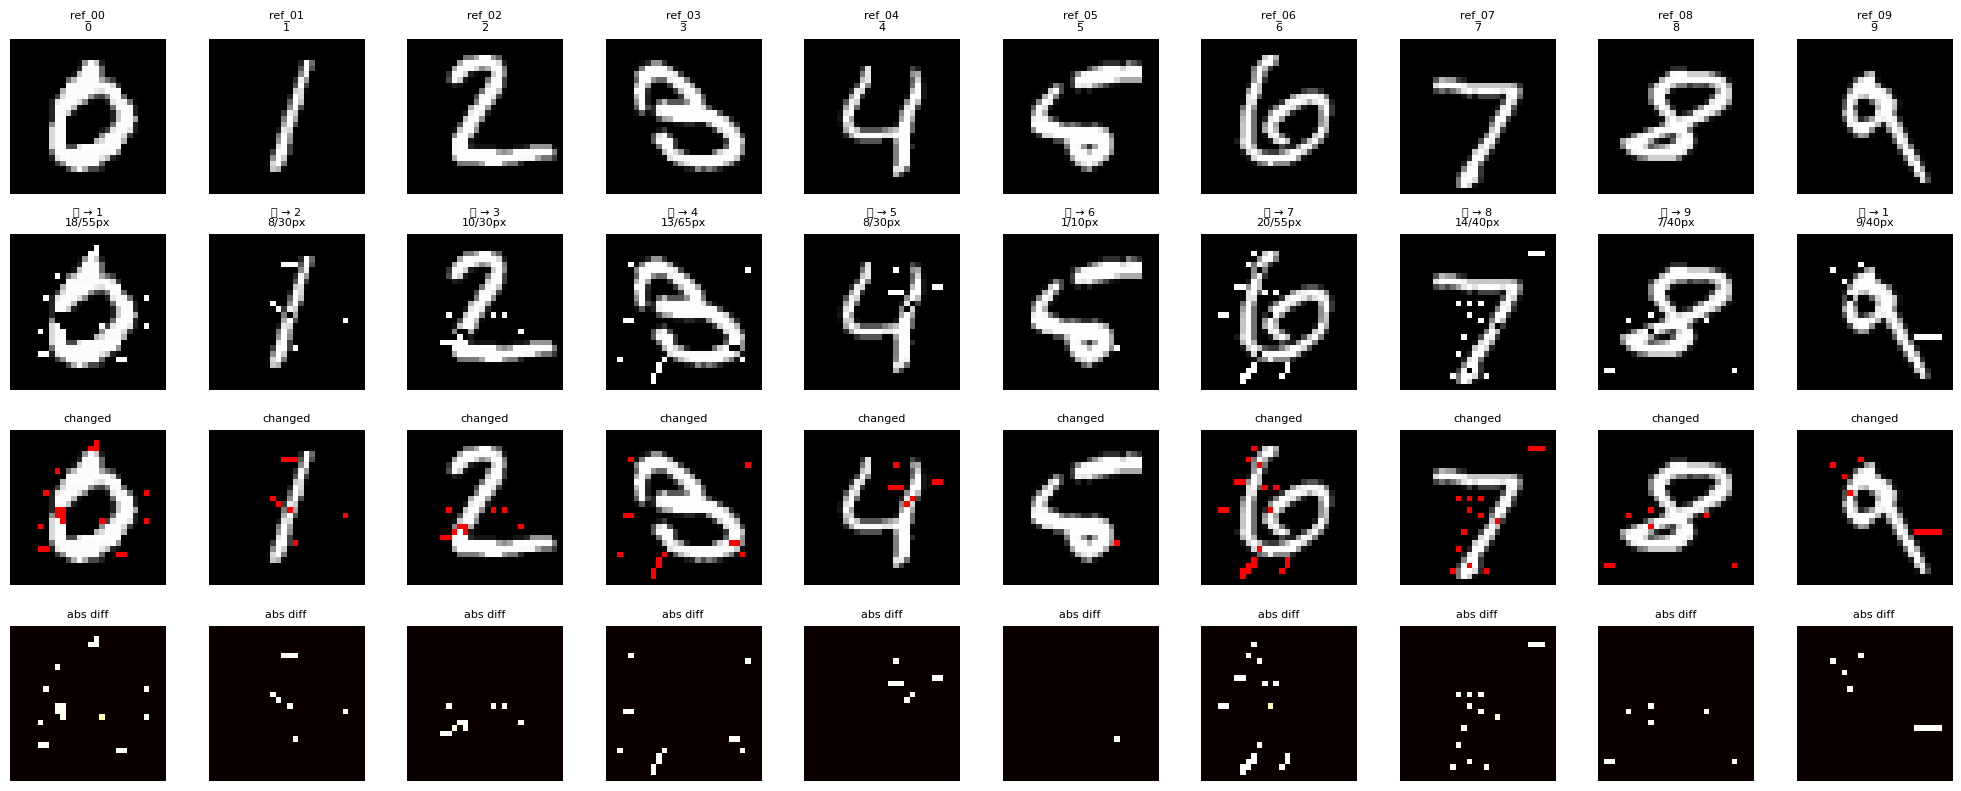


SUMMARY
Success: 10/10

  ✅ [00] 0→1: pred=1, pixels=18/55
  ✅ [01] 1→2: pred=2, pixels=8/30
  ✅ [02] 2→3: pred=3, pixels=10/30
  ✅ [03] 3→4: pred=4, pixels=13/65
  ✅ [04] 4→5: pred=5, pixels=8/30
  ✅ [05] 5→6: pred=6, pixels=1/10
  ✅ [06] 6→7: pred=7, pixels=20/55
  ✅ [07] 7→8: pred=8, pixels=14/40
  ✅ [08] 8→9: pred=9, pixels=7/40
  ✅ [09] 9→1: pred=1, pixels=9/40


In [ ]:
# ============================================
# 전체 10개 이미지에 대한 Adversarial Attack
# ============================================

import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# Config에서 가져온 설정
TARGET_CLASS_IDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 1]
REFERENCE_CLASS_IDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
BUDGETS = [55, 30, 30, 65, 30, 10, 55, 40, 40, 40]

def greedy_one_pixel_attack(
    ref_img: Image.Image,
    bundle: ModelBundle,
    source_class: int,
    target_class: int,
    budget: int,
    verbose: bool = True
):
    """
    Greedy 방식: 한 픽셀씩 변경해서 target 확률이 가장 많이 오르는 픽셀 선택
    """
    device = next(bundle.model.parameters()).device

    orig_arr = np.array(ref_img.convert("L"), dtype=np.uint8)
    adv_arr = orig_arr.copy()
    changed_pixels = set()

    for pixel_count in range(budget):
        # 현재 target class 확률
        adv_img = Image.fromarray(adv_arr, mode="L")
        with torch.no_grad():
            x = bundle.preprocess_pil(adv_img).unsqueeze(0).to(device)
            logits = bundle.model(x)
            probs = F.softmax(logits, dim=1)[0]
            current_target_prob = probs[target_class].item()
            current_pred = torch.argmax(probs).item()

        if current_pred == target_class:
            if verbose:
                print(f"  ✅ Success with {len(changed_pixels)} pixels!")
            return adv_arr, changed_pixels, True

        if verbose and pixel_count % 10 == 0:
            print(f"  Pixel {pixel_count}: pred={current_pred}, target_prob={current_target_prob:.4f}")

        # 모든 픽셀 x 몇 가지 값 조합 시도
        candidates = []

        for r in range(28):
            for c in range(28):
                if (r, c) in changed_pixels:
                    continue

                for new_val in [0, 64, 128, 192, 255]:
                    if new_val == orig_arr[r, c]:
                        continue

                    # 임시로 변경
                    old_val = adv_arr[r, c]
                    adv_arr[r, c] = new_val

                    # 예측
                    test_img = Image.fromarray(adv_arr, mode="L")
                    with torch.no_grad():
                        x = bundle.preprocess_pil(test_img).unsqueeze(0).to(device)
                        logits = bundle.model(x)
                        probs = F.softmax(logits, dim=1)[0]
                        target_prob = probs[target_class].item()

                    candidates.append((target_prob, r, c, new_val))

                    # 복원
                    adv_arr[r, c] = old_val

        if not candidates:
            break

        # 가장 좋은 후보 선택
        candidates.sort(reverse=True)
        best_prob, best_r, best_c, best_val = candidates[0]

        # 적용
        adv_arr[best_r, best_c] = best_val
        changed_pixels.add((best_r, best_c))

    # 최종 체크
    adv_img = Image.fromarray(adv_arr, mode="L")
    pred = predict_top1(adv_img, bundle)
    success = (pred["id"] == target_class)

    return adv_arr, changed_pixels, success


def run_all_attacks():
    """모든 10개 이미지에 대해 adversarial attack 실행"""

    device = next(bundle.model.parameters()).device
    print(f"Device: {device}")
    print("=" * 60)

    # 결과 저장 디렉토리
    os.makedirs("adversarial_outputs", exist_ok=True)

    results = []

    for i in range(10):
        source_class = REFERENCE_CLASS_IDS[i]
        target_class = TARGET_CLASS_IDS[i]
        budget = BUDGETS[i]

        print(f"\n[{i:02d}] ref_{i:02d}.png: {source_class} → {target_class} (budget: {budget})")
        print("-" * 50)

        # 이미지 로드 (루트에서)
        ref_path = f"ref_{i:02d}.png"
        ref_img = Image.open(ref_path).convert("L")

        # 원본 예측 확인
        orig_pred = predict_top1(ref_img, bundle)
        print(f"  Original prediction: {orig_pred['id']} (prob: {orig_pred['prob']:.4f})")

        if orig_pred['id'] != source_class:
            print(f"  ⚠️ Warning: Original prediction {orig_pred['id']} != expected {source_class}")

        # Adversarial attack
        adv_arr, changed_pixels, success = greedy_one_pixel_attack(
            ref_img, bundle, source_class, target_class, budget, verbose=True
        )

        # 결과 확인
        adv_img = Image.fromarray(adv_arr, mode="L")
        adv_pred = predict_top1(adv_img, bundle)
        pixel_diff = len(changed_pixels)

        # 저장
        output_path = f"adversarial_outputs/adv_{i:02d}.png"
        adv_img.save(output_path)

        result = {
            'index': i,
            'source': source_class,
            'target': target_class,
            'budget': budget,
            'pixel_diff': pixel_diff,
            'final_pred': adv_pred['id'],
            'final_prob': adv_pred['prob'],
            'success': success and (pixel_diff <= budget),
            'adv_arr': adv_arr,
            'changed_pixels': changed_pixels
        }
        results.append(result)

        status = "✅" if result['success'] else "❌"
        print(f"  {status} Final: pred={adv_pred['id']}, prob={adv_pred['prob']:.4f}, pixels={pixel_diff}/{budget}")

    return results


def visualize_results(results):
    """결과 시각화"""
    fig, axes = plt.subplots(4, 10, figsize=(20, 8))

    for i, res in enumerate(results):
        ref_path = f"ref_{i:02d}.png"
        ref_img = Image.open(ref_path).convert("L")
        ref_arr = np.array(ref_img)
        adv_arr = res['adv_arr']

        # Row 0: Original
        axes[0, i].imshow(ref_arr, cmap='gray', vmin=0, vmax=255)
        axes[0, i].set_title(f"ref_{i:02d}\n{res['source']}", fontsize=8)
        axes[0, i].axis('off')

        # Row 1: Adversarial
        status = "✅" if res['success'] else "❌"
        axes[1, i].imshow(adv_arr, cmap='gray', vmin=0, vmax=255)
        axes[1, i].set_title(f"{status} → {res['final_pred']}\n{res['pixel_diff']}/{res['budget']}px", fontsize=8)
        axes[1, i].axis('off')

        # Row 2: Diff (changed pixels in red)
        diff_rgb = np.stack([ref_arr, ref_arr, ref_arr], axis=-1)
        for (r, c) in res['changed_pixels']:
            diff_rgb[r, c] = [255, 0, 0]
        axes[2, i].imshow(diff_rgb)
        axes[2, i].set_title(f"changed", fontsize=8)
        axes[2, i].axis('off')

        # Row 3: Absolute difference
        abs_diff = np.abs(adv_arr.astype(int) - ref_arr.astype(int)).astype(np.uint8)
        axes[3, i].imshow(abs_diff, cmap='hot', vmin=0, vmax=255)
        axes[3, i].set_title(f"abs diff", fontsize=8)
        axes[3, i].axis('off')

    axes[0, 0].set_ylabel("Original", fontsize=10)
    axes[1, 0].set_ylabel("Adversarial", fontsize=10)
    axes[2, 0].set_ylabel("Changed", fontsize=10)
    axes[3, 0].set_ylabel("Diff", fontsize=10)

    plt.tight_layout()
    plt.savefig("adversarial_outputs/all_results.png", dpi=150)
    plt.show()

    # Summary
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)
    success_count = sum(1 for r in results if r['success'])
    print(f"Success: {success_count}/10")
    print()
    for res in results:
        status = "✅" if res['success'] else "❌"
        print(f"  {status} [{res['index']:02d}] {res['source']}→{res['target']}: "
              f"pred={res['final_pred']}, pixels={res['pixel_diff']}/{res['budget']}")


# ============================================
# 실행
# ============================================

print("🔥 Starting Adversarial Attack on all 10 images...")
print(f"Config:")
print(f"  Targets: {TARGET_CLASS_IDS}")
print(f"  Budgets: {BUDGETS}")

results = run_all_attacks()
visualize_results(results)